In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random


C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [39]:
#dataset = "../../Pics/Track/Datasets_Axionable/ironcar_pics"
dataset = "../../Pics/cleaned1"
#dataset = "../../Pics/tagged2"
#dataset = "../../Pics/Track/OldDataset_balanced"
#dataset = "../../Pics/Track/Mixed"
#dataset = "../../Pics/Balanced"
#dataset = "../../Pics/testTrack"
#dataset = "../../Pics/testTrack_3"

In [40]:
# load images from both train and test groups
directory = '../../' + dataset
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 9294


In [41]:
#Normalise images
images = np.array(images)
images /= 255

In [42]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([1, 0], dtype=uint8),
 array([0, 0, 0, 1, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x1b7836a2cc0>)

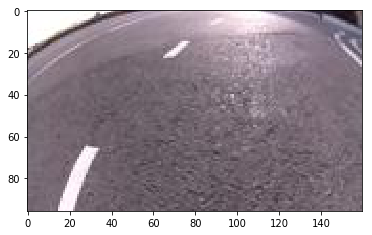

In [43]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [44]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [63]:
K.clear_session()
############################################################# Multitask Model  

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (6,4), strides=(2,2), activation='relu')(x)
x = Convolution2D(4, (4,2), strides=(2,1), activation='relu')(x)
x = BatchNormalization()(x)

flat = Flatten()(x)

x = Dense(10)(flat)
x = Activation('relu')(x)

out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 149, 2)   74          img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 142, 4)   68          conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 142, 4)   16          conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [58]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=128, epochs=10, verbose=1, validation_split=0.3)

Train on 6505 samples, validate on 2789 samples
Epoch 1/10
6505/6505 [==============================] - 31s 5ms/step - loss: 1.6765 - dense_2_loss: 0.3387 - dense_3_loss: 1.3378 - dense_2_acc: 0.8546 - dense_3_acc: 0.4644 - val_loss: 1.8951 - val_dense_2_loss: 0.6158 - val_dense_3_loss: 1.2792 - val_dense_2_acc: 0.8630 - val_dense_3_acc: 0.5005
Epoch 2/10
5120/6505 [======================>.......] - ETA: 5s - loss: 1.1059 - dense_2_loss: 0.2103 - dense_3_loss: 0.8956 - dense_2_acc: 0.9215 - dense_3_acc: 0.6609

KeyboardInterrupt: 

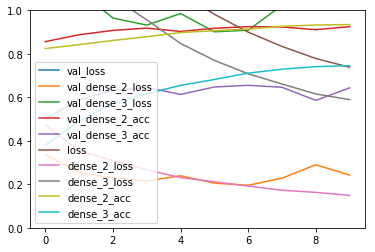

In [51]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [12]:
model.save('model_multi_testTrack.h5')

In [32]:
#######################  VALIDATION

#dataset = "../../Pics/Track/Datasets_Axionable/ironcar_pics"
#dataset = "../../Pics/cleaned1"
#dataset = "../../Pics/tagged2"
dataset = "../../Pics/Track/OldDataset_balanced"
#dataset = "../../Pics/Track/Mixed"
#dataset = "../../Pics/Balanced"
#dataset = "../../Pics/testTrack"
#dataset = "../../Pics/testTrack_3"

In [33]:
def load_photos_val(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [34]:
# load images from both train and test groups
directory = '../../' + dataset
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images = len(images_val)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 1699


In [35]:
images_val = np.array(images_val)
images_val /= 255

In [36]:
# Get predictions
all_preds = model.predict(images_val)

speed_preds = []
for elem in all_preds[0]:
    speed_preds.append(np.argmax(elem))
    
dir_preds = []
for elem in all_preds[1]:
    dir_preds.append(np.argmax(elem))

In [37]:
res = 0
for i, value in enumerate(speed_preds):
    if value != labels_speed_val[i]:
        res = res + 1
print("error_rate = " + str(res/i))

error_rate = 0.2585394581861013


In [38]:
res = 0
for i, value in enumerate(dir_preds):
    if value != labels_dir_val[i]:
        res = res + 1
print("error_rate = " + str(res/i))

error_rate = 0.8510011778563016
